# Análise da reincidência por cliente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
all_orders = pd.read_csv('../datasets/trusted/all_orders.csv')
all_orders.count()

Unnamed: 0                       99441
order_id                         99441
customer_unique_id               99441
customer_city                    99441
customer_state                   99441
order_approved_at                99281
order_purchase_timestamp         99441
order_estimated_delivery_date    99441
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
dtype: int64

In [3]:
times_bought = all_orders.groupby(['customer_unique_id']).agg('count')['order_id'].sort_values(ascending=False)
times_bought.head(10)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
63cfc61cee11cbe306bff5857d00bfe4     6
47c1a3033b8b77b3ab6e109eb4d5fdf3     6
dc813062e0fc23409cd255f7f53c7074     6
de34b16117594161a6a89c50b289d35a     6
f0e310a6839dce9de1638e0fe5ab282a     6
Name: order_id, dtype: int64

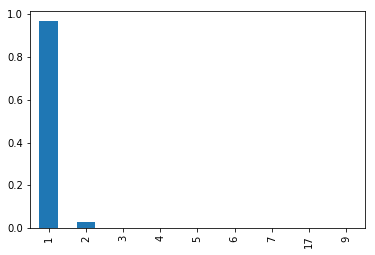

In [4]:
times_bought.value_counts(normalize=True).plot.bar()

Como é possível observar com o gráfico, a grande maioria dos clientes compra apenas uma vez.

In [5]:
more_than_once = all_orders.loc[np.where(times_bought > 1)]
more_than_once.count()

Unnamed: 0                       2997
order_id                         2997
customer_unique_id               2997
customer_city                    2997
customer_state                   2997
order_approved_at                2992
order_purchase_timestamp         2997
order_estimated_delivery_date    2997
order_delivered_carrier_date     2953
order_delivered_customer_date    2917
dtype: int64

## Hipótese: a região dos consumidores afeta se eles voltam a comprar ou não

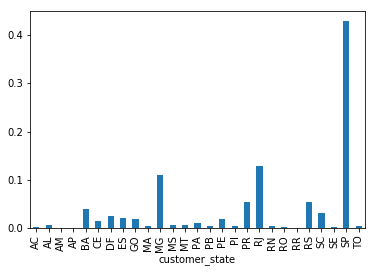

In [6]:
mto_by_state = more_than_once.groupby(['customer_state']).agg('count')['order_id']
(mto_by_state / more_than_once.count()[0]).plot.bar()

A maior parte dos clientes que volta é do estado de são paulo.

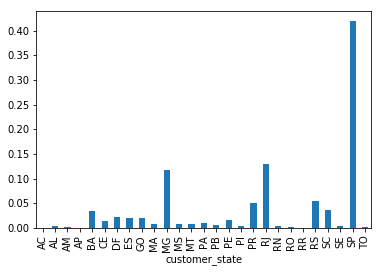

In [7]:
all_by_state = all_orders.groupby(['customer_state']).agg('count')['order_id']
(all_by_state / all_orders.count()[0]).plot.bar()

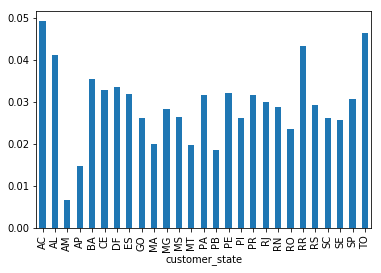

In [8]:
(mto_by_state / all_by_state).plot.bar()

In [9]:
pd.DataFrame({'mto': mto_by_state, 'all': all_by_state }).corr()['mto']['all']

0.9994653387646663

In [10]:
print(stats.kruskal(all_by_state / all_orders.count()[0], mto_by_state / more_than_once.count()[0]).pvalue * 100, '%', sep='')

88.30838631048043%


Fazendo uma análise da quantidade de clientes por estado, porém, percebe-se que a distribuição é quase exatamente a mesma. O P-Value para o teste de kruskal também é alto, indicando alta probabilidade de que a distribuição é idêntica.

É razoável assumir que o estado não tem nenhum tipo de efeito em se o cliente volta a comprar ou não.

## Hipótese: o atraso nas entregas afetam se as pessoas voltam ou não

In [11]:
def delivery_delay(order):
    estimated = pd.to_datetime(order['order_estimated_delivery_date'])
    delivered = pd.to_datetime(order['order_delivered_customer_date'])
    return delivered - estimated

In [12]:
delays_in_days_mto = delivery_delay(more_than_once) / np.timedelta64(24, 'h')
delays_in_days_all = delivery_delay(all_orders) / np.timedelta64(24, 'h')

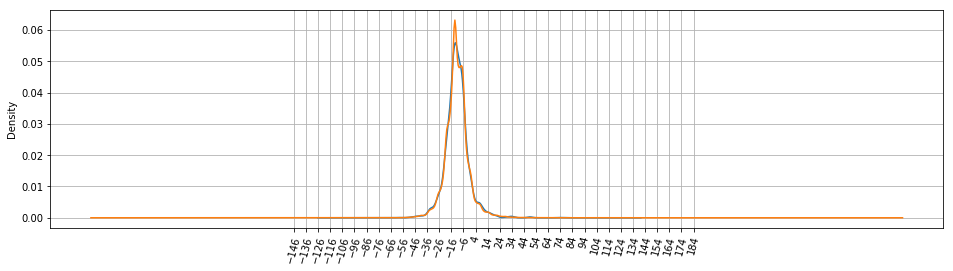

In [13]:
delays_in_days_mto.plot.kde(
    figsize=(16, 4),
    xticks=range(int(delays_in_days_mto.min()),
                 int(delays_in_days_mto.max()),
                 10),
    rot=75,
    grid=True)

delays_in_days_all.plot.kde(
    figsize=(16, 4),
    xticks=range(int(delays_in_days_all.min()),
                 int(delays_in_days_all.max()),
                 10),
    rot=75,
    grid=True)

In [14]:
ddmto = delays_in_days_mto.value_counts(normalize=True).sort_index()
ddmto.values

array([0.00034282, 0.00034282, 0.00034282, ..., 0.00034282, 0.00034282,
       0.00034282])

In [22]:
ddall = delays_in_days_all.iloc[ddmto.index.min():ddmto.index.max()].value_counts(normalize=True).sort_index()
ddall.values

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [-59.470162037037035] of <class 'numpy.float64'>

In [19]:
stats.kruskal(ddmto.values, ddall.values).pvalue

0.0

A maioria das entregas para clientes que voltam acontecem dentro do prazo estipulado, e em sua maior parte adiantadas, com o pico no KDE no valor de -12 dias de "atraso", ou seja, 12 dias adiantado.

Para o total das entregas, no entanto, observa-se o mesmo padrão. É possível que as entregas adiantadas não sejam a causa da volta dos clientes para mais compras.